In [21]:
import os

# Prepend Homebrew binaries to PATH for subprocess
os.environ["PATH"] = "/opt/homebrew/bin:" + os.environ.get("PATH", "")

# Optional: check it worked
!which fluidsynth

/opt/homebrew/bin/fluidsynth


## Preprocessing

### Tempo normalization + Synthesize MIDI + Split data 

Synthesize MIDI files to audio with tempo normalization and create train/test splits.
Normalizes all MIDI to 120 BPM, synthesizes to audio, verifies with librosa, and filters.


In [22]:
import pretty_midi
import librosa
import numpy as np
from pathlib import Path
import json
from tqdm import tqdm
import subprocess
import shutil
from IPython.display import Audio
import random

# Paths
MIDI_DIR = Path("./datasets/PPDD-Jul2018_aud_mono_small/prime_midi")
CONTINUATION_DIR = Path("./datasets/PPDD-Jul2018_aud_mono_small/cont_true_midi")

OUTPUT_BASE = Path("./normalized_dataset")
TRAIN_DIR = OUTPUT_BASE / "train"
TEST_DIR = OUTPUT_BASE / "test"

# Create directories
TRAIN_DIR.mkdir(parents=True, exist_ok=True)
TEST_DIR.mkdir(parents=True, exist_ok=True)


In [23]:

def normalize_midi_tempo(midi_file_path, target_bpm=120.0):
    """
    Normalize MIDI file to target BPM by scaling note timings.

    Args:
        midi_file_path: Path to MIDI file
        target_bpm: Target tempo in BPM

    Returns:
        pretty_midi.PrettyMIDI object with normalized tempo
    """
    midi = pretty_midi.PrettyMIDI(midi_file_path)

    # Get original tempo
    original_bpm = midi.get_tempo_changes()[1][0]
    tempo_ratio = target_bpm / original_bpm

    # Scale note timings
    for instrument in midi.instruments:
        for note in instrument.notes:
            note.start *= tempo_ratio
            note.end *= tempo_ratio
        for cc in instrument.control_changes:
            cc.time *= tempo_ratio
        for pb in instrument.pitch_bends:
            pb.time *= tempo_ratio

        # Reset to program 0 (piano)
        if not instrument.is_drum:
            instrument.program = 0
            instrument.channel = 0

    # Set constant tempo
    midi._tempo_changes = ([0.0], [target_bpm])

    return midi


def synthesize_midi(midi_file_path, output_audio_path, soundfont_path):
    """
    Synthesize MIDI to audio using FluidSynth.

    Args:
        midi_file_path: Path to MIDI file
        output_audio_path: Path to save audio
        soundfont_path: Path to soundfont

    Returns:
        True if successful
    """
    try:
        cmd = [
            "fluidsynth",
            "-ni",
            "-g", "3.0", # increase gain to match the volume of the original wav file
            "-r", "22050",  # Sample rate to match spectrogram extraction
            "-F", str(output_audio_path),
            str(soundfont_path),
            str(midi_file_path)
        ]
        result = subprocess.run(cmd, capture_output=True, timeout=60)
        return result.returncode == 0
    except Exception as e:
        print(f"    Error synthesizing: {e}")
        return False


def verify_tempo(audio_path, sr=22050, target_bpm=120.0, tolerance=5.0):
    """
    Verify audio tempo using librosa, accepting tempo octaves.

    Args:
        audio_path: Path to audio file
        sr: Sample rate
        target_bpm: Expected BPM
        tolerance: Allowed deviation in BPM (default ±5)

    Returns:
        Tuple of (is_valid, detected_bpm)
    """
    try:
        y, _ = librosa.load(audio_path, sr=sr)
        detected_bpm = librosa.feature.tempo(y=y, sr=sr)[0]

        # Check if detected BPM matches target or tempo octaves (x0.5, x2)
        octave_bpms = [target_bpm / 2, target_bpm, target_bpm * 2]
        is_valid = any(abs(detected_bpm - bpm) <= tolerance for bpm in octave_bpms)

        return is_valid, detected_bpm
    except Exception as e:
        return False, None

def find_soundfont():
    """Find available FluidSynth soundfont."""
    paths = "./UprightPianoKW-small-20190703.sf2"

    return paths




In [24]:

# ========================
# Test Tempo Normalization
# ========================

# Normalize MIDI
midi_file = "./tests/0ef0042b-f34a-4fa0-9acf-261159083e2b.mid"
print("normalizing midi")
normalized_midi = normalize_midi_tempo(str(midi_file), 120)

# Save normalized MIDI
print("saving midi")
temp_midi_path = f"./tests/normalized.mid"
normalized_midi.write(str(temp_midi_path))

# Synthesize to audio
print("synthesizing midi")
synthesize_midi(str(temp_midi_path), str('./tests/normalized.wav'), "./UprightPianoKW-small-20190703.sf2")

normalizing midi
saving midi
synthesizing midi


True

In [25]:


def process_dataset(target_bpm=120.0):
    """
    Process all MIDI files: normalize, synthesize, verify, and split.

    Args:
        target_bpm: Target tempo for normalization

    Returns:
        Dictionary with dataset info
    """
    # Find soundfont
    soundfont = find_soundfont()
    if not soundfont:
        print("ERROR: FluidSynth soundfont not found!")
        return None
    print(f"Using soundfont: {soundfont}\n")

    # Get all MIDI files
    midi_files = sorted(list(MIDI_DIR.glob('*.mid')) + list(MIDI_DIR.glob('*.midi')))
    continuation_files = {f.stem: f for f in list(CONTINUATION_DIR.glob('*.mid')) + list(CONTINUATION_DIR.glob('*.midi'))} if CONTINUATION_DIR.exists() else {}

    print(f"Found {len(midi_files)} MIDI files")
    print(f"Found {len(continuation_files)} continuation files\n")

    # Process each MIDI file
    stats = {
        'total': len(midi_files),
        'synthesized': 0,
        'verified': 0,
        'failed': 0,
        'bpms': [],
        'failed_files': [],
        'train_files': [],
        'test_files': []
    }

    temp_midi_dir = OUTPUT_BASE / "temp_normalized_midi"
    temp_midi_dir.mkdir(exist_ok=True)

    print("=" * 70)
    print("STEP 1: Normalize and synthesize MIDI files")
    print("=" * 70)

    valid_pairs = []  # (name, midi_path, audio_path)

    for i, midi_file in enumerate(tqdm(midi_files, desc="Processing", unit="file")):
        name = midi_file.stem

        try:
            # Normalize MIDI
            normalized_midi = normalize_midi_tempo(str(midi_file), target_bpm)

            # Save normalized MIDI
            temp_midi_path = temp_midi_dir / f"{name}_normalized.mid"
            normalized_midi.write(str(temp_midi_path))

            # Synthesize to audio
            audio_path = OUTPUT_BASE / f"{name}.wav"
            if synthesize_midi(str(temp_midi_path), str(audio_path), soundfont):
                stats['synthesized'] += 1

                # Verify tempo
                is_valid, detected_bpm = verify_tempo(str(audio_path), target_bpm=target_bpm)

                if is_valid:
                    stats['verified'] += 1
                    stats['bpms'].append(detected_bpm)
                    valid_pairs.append((name, str(midi_file), str(audio_path)))
                else:
                    stats['failed'] += 1
                    stats['failed_files'].append(f"{name} (detected: {detected_bpm:.1f} BPM)")
            else:
                stats['failed'] += 1
                stats['failed_files'].append(f"{name} (synthesis failed)")

        except Exception as e:
            stats['failed'] += 1
            stats['failed_files'].append(f"{name} ({str(e)})")

    print("\n" + "=" * 70)
    print("STEP 2: Split into train/test (80/20)")
    print("=" * 70)

    # Split 80/20
    random.shuffle(valid_pairs)
    n_train = int(len(valid_pairs) * 0.8)
    train_pairs = valid_pairs[:n_train]
    test_pairs = valid_pairs[n_train:]

    print(f"Train set: {len(train_pairs)} files")
    print(f"Test set: {len(test_pairs)} files\n")

    # Copy train files
    print("Copying training files...")
    for name, midi_path, audio_path in tqdm(train_pairs, desc="Train", unit="file"):
        shutil.copy(audio_path, TRAIN_DIR / f"{name}.wav")

        # Add continuation if available
        if name in continuation_files:
            cont_midi = continuation_files[name]
            cont_audio = TRAIN_DIR / f"{name}_continuation.wav"

            # # Normalize and synthesize continuation
            # try:
            #     normalized_cont = normalize_midi_tempo(str(cont_midi), target_bpm)
            #     temp_cont_midi = temp_midi_dir / f"{name}_continuation_normalized.mid"
            #     normalized_cont.write(str(temp_cont_midi))
            #     synthesize_midi(str(temp_cont_midi), str(cont_audio), soundfont)
            # except:
            #     pass

        stats['train_files'].append(name)

    # Copy test files
    print("Copying test files...")
    test_continuation_dir = TEST_DIR / "continuation_midi"
    test_continuation_dir.mkdir(exist_ok=True)

    for name, midi_path, audio_path in tqdm(test_pairs, desc="Test", unit="file"):
        shutil.copy(audio_path, TEST_DIR / f"{name}.wav")

        # Save normalized continuation MIDI if available (for evaluation ground truth)
        if name in continuation_files:
            cont_midi = continuation_files[name]
            cont_output = test_continuation_dir / f"{name}_continuation.mid"

            # Normalize and save continuation MIDI
            try:
                normalized_cont = normalize_midi_tempo(str(cont_midi), target_bpm)
                normalized_cont.write(str(cont_output))
            except Exception as e:
                print(f"    Warning: Could not process continuation for {name}: {e}")

        stats['test_files'].append(name)

    # Clean up temp directory
    shutil.rmtree(temp_midi_dir)

    # Print summary
    print("\n" + "=" * 70)
    print("SUMMARY")
    print("=" * 70)
    print(f"Files processed: {stats['synthesized']}")
    print(f"Files verified (120 BPM ±2): {stats['verified']}")
    print(f"Files failed: {stats['failed']}")

    if stats['bpms']:
        bpms = np.array(stats['bpms'])
        print(f"Mean detected BPM: {np.mean(bpms):.1f}")
        print(f"Std dev: {np.std(bpms):.2f}")

    if stats['failed_files']:
        print(f"\nFailed files ({len(stats['failed_files'])}):")
        for f in stats['failed_files'][:10]:
            print(f"  - {f}")
        if len(stats['failed_files']) > 10:
            print(f"  ... and {len(stats['failed_files']) - 10} more")

    print(f"\nDataset saved to: {OUTPUT_BASE}")
    print(f"  Train: {TRAIN_DIR} ({len(stats['train_files'])} files)")
    print(f"  Test: {TEST_DIR} ({len(stats['test_files'])} files)")

    # Save stats
    stats_file = OUTPUT_BASE / "dataset_stats.json"
    with open(stats_file, 'w') as f:
        json.dump({
            'total': stats['total'],
            'synthesized': stats['synthesized'],
            'verified': stats['verified'],
            'failed': stats['failed'],
            'mean_bpm': float(np.mean(stats['bpms'])) if stats['bpms'] else None,
            'std_bpm': float(np.std(stats['bpms'])) if stats['bpms'] else None,
            'train_count': len(stats['train_files']),
            'test_count': len(stats['test_files']),
            'failed_files': stats['failed_files']
        }, f, indent=2)

    print(f"\nStats saved to: {stats_file}")

    return stats


process_dataset(target_bpm=120.0)

Using soundfont: ./UprightPianoKW-small-20190703.sf2

Found 100 MIDI files
Found 100 continuation files

STEP 1: Normalize and synthesize MIDI files


Processing: 100%|██████████| 100/100 [00:16<00:00,  6.20file/s]



STEP 2: Split into train/test (80/20)
Train set: 60 files
Test set: 15 files

Copying training files...


Train: 100%|██████████| 60/60 [00:00<00:00, 814.42file/s]


Copying test files...


Test: 100%|██████████| 15/15 [00:00<00:00, 428.03file/s]


SUMMARY
Files processed: 100
Files verified (120 BPM ±2): 75
Files failed: 25
Mean detected BPM: 113.1
Std dev: 15.67

Failed files (25):
  - 0cdc1aa9-ae7e-4bf0-9f74-9b5b31f3f84b (detected: 80.7 BPM)
  - 126806ab-1258-436a-860e-7e53e04fac31 (detected: 80.7 BPM)
  - 1458c887-280e-4e11-9e34-9ecfb7e6970e (detected: 184.6 BPM)
  - 182fa8dd-1dd5-4d77-b22e-98d734236dc8 (detected: 172.3 BPM)
  - 2592ce2c-13b4-4fbf-8427-5076ac2adee6 (detected: 89.1 BPM)
  - 2dd27791-618c-4035-8486-32f25476dc40 (detected: 80.7 BPM)
  - 33d5a8c4-fd03-45d8-82b0-2a9d53e06752 (detected: 95.7 BPM)
  - 34adf640-04d3-4d6e-b61f-7c5e53e1ad59 (detected: 80.7 BPM)
  - 44690756-b437-4f5c-9860-bcce8f3e0a03 (detected: 95.7 BPM)
  - 46559eb2-3a8c-41da-b326-18029939a36e (detected: 80.7 BPM)
  ... and 15 more

Dataset saved to: normalized_dataset
  Train: normalized_dataset/train (60 files)
  Test: normalized_dataset/test (15 files)

Stats saved to: normalized_dataset/dataset_stats.json


{'total': 100,
 'synthesized': 100,
 'verified': 75,
 'failed': 25,
 'bpms': [np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(60.09265988372093),
  np.float64(123.046875),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(60.09265988372093),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(60.09265988372093),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(60.09265988372093),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.4

### Spectrogram Extraction

In [26]:
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def slice_waveform(y, sr=22050, slice_sec=0.125, n_fft=2048, hop_length=512, n_mels=128, pad=True):
    """
    Convert audio waveform into fixed-length Mel spectrogram slices.
    
    Args:
        y: audio waveform
        sr: sample rate
        slice_sec: duration of each slice in seconds
        n_fft, hop_length, n_mels: Mel spectrogram parameters
        pad: whether to pad last slice if shorter
    
    Returns:
        slices: list of (n_mels, frames_per_slice) arrays
    """
    # Full Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    
    frames_per_slice = int(slice_sec * sr / hop_length)
    slices = []
    for start in range(0, S_db.shape[1], frames_per_slice):
        end = start + frames_per_slice
        slice_ = S_db[:, start:end]
        if pad and slice_.shape[1] < frames_per_slice:
            pad_width = frames_per_slice - slice_.shape[1]
            slice_ = np.pad(slice_, ((0,0),(0,pad_width)), mode='constant')
        slices.append(slice_.astype(np.float32))
    
    return slices, S_db



def extract_spectrograms(audio_files, sr=22050, note_fraction=0.25, n_fft=2048, n_mels=128, pad=True, visualize=False):
    quarter_note_sec = 60 / 120.0
    slice_duration_sec = quarter_note_sec * note_fraction
    
    sequences = []
    hop_length = 512  # standard hop_length for mel spectrogram

    for idx, audio_path in enumerate(audio_files):
        y, _ = librosa.load(audio_path, sr=sr)
        slices, S_db = slice_waveform(y, sr=sr, slice_sec=slice_duration_sec,
                                      n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, pad=pad)
        sequences.append(slices)

        if visualize and idx == 0:
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"Mel spectrogram: {audio_path.name}")
            plt.show()
            print(f"First piece's spectrogram shape: {S_db.shape}, Num slices: {len(slices)}")
    
    return sequences, slice_duration_sec, hop_length




In [27]:
dev_test_audio_files = list(Path("./tests").glob('*.wav'))
dev_test_sequences_no_pad, slice_duration_sec, hop_length = extract_spectrograms(dev_test_audio_files, pad=False)

for i, audio_seq in enumerate(dev_test_sequences_no_pad):
    print(f"Audio file {i} has {len(audio_seq)} slices (n_mels, frames_per_slice)")
    for j, slice_ in enumerate(audio_seq[:3]):
        print(f"  Slice {j}: {slice_.shape}")
    print("  ......")
    for j, slice_ in enumerate(audio_seq[-3:]):
        print(f"  Slice {len(audio_seq)-3+j}: {slice_.shape}")

print(f"Sometimes the last slice has less frames than other slices, so we need to pad it.")

print("="*70)
print(f"After padding:")

dev_test_sequences, slice_duration_sec, hop_length = extract_spectrograms(dev_test_audio_files, pad=True)

for i, audio_seq in enumerate(dev_test_sequences):
    print(f"Audio file {i} has {len(audio_seq)} slices (n_mels, frames_per_slice)")
    for j, slice_ in enumerate(audio_seq[:3]):
        print(f"  Slice {j}: {slice_.shape}")
    print("  ......")
    for j, slice_ in enumerate(audio_seq[-3:]):
        print(f"  Slice {len(audio_seq)-3+j}: {slice_.shape}")


Audio file 0 has 320 slices (n_mels, frames_per_slice)
  Slice 0: (128, 5)
  Slice 1: (128, 5)
  Slice 2: (128, 5)
  ......
  Slice 317: (128, 5)
  Slice 318: (128, 5)
  Slice 319: (128, 3)
Audio file 1 has 225 slices (n_mels, frames_per_slice)
  Slice 0: (128, 5)
  Slice 1: (128, 5)
  Slice 2: (128, 5)
  ......
  Slice 222: (128, 5)
  Slice 223: (128, 5)
  Slice 224: (128, 5)
Audio file 2 has 309 slices (n_mels, frames_per_slice)
  Slice 0: (128, 5)
  Slice 1: (128, 5)
  Slice 2: (128, 5)
  ......
  Slice 306: (128, 5)
  Slice 307: (128, 5)
  Slice 308: (128, 3)
Sometimes the last slice has less frames than other slices, so we need to pad it.
After padding:
Audio file 0 has 320 slices (n_mels, frames_per_slice)
  Slice 0: (128, 5)
  Slice 1: (128, 5)
  Slice 2: (128, 5)
  ......
  Slice 317: (128, 5)
  Slice 318: (128, 5)
  Slice 319: (128, 5)
Audio file 1 has 225 slices (n_mels, frames_per_slice)
  Slice 0: (128, 5)
  Slice 1: (128, 5)
  Slice 2: (128, 5)
  ......
  Slice 222: (128, 

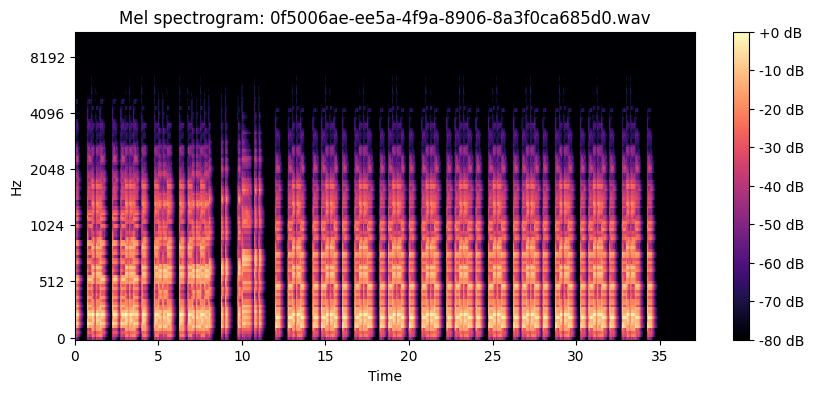

First piece's spectrogram shape: (128, 1598), Num slices: 320
Playing the first slice:
Playing reconstructed full audio from all slices:


In [28]:
dev_test_audio_files = list(Path("./tests").glob('*.wav'))
dev_test_sequences, slice_duration_sec, hop_length = extract_spectrograms(dev_test_audio_files, visualize=True)
sr = 22050  # sample rate, must match what you used

# take first audio file, first slice
first_seq = dev_test_sequences[0] # shape: (num_slices, n_mels)
first_slice_db = first_seq[0]
first_slice_power = librosa.db_to_power(first_slice_db)
y_slice = librosa.feature.inverse.mel_to_audio(first_slice_power, sr=sr, n_fft=2048, hop_length=hop_length)
print("Playing the first slice:")
Audio(y_slice, rate=sr)

# Convert dB back to power
full_spectrogram_db = np.hstack(first_seq)  # shape: (n_mels, total_frames)
full_spectrogram_power = librosa.db_to_power(full_spectrogram_db)
# Reconstruct full waveform
y_full = librosa.feature.inverse.mel_to_audio(full_spectrogram_power, sr=sr, n_fft=2048, hop_length=hop_length)
print("Playing reconstructed full audio from all slices:")
Audio(y_full, rate=sr)

### K-Means Quantization of Spectrogram (Encoding Function)

Quantizing 854 slices into 64 clusters...


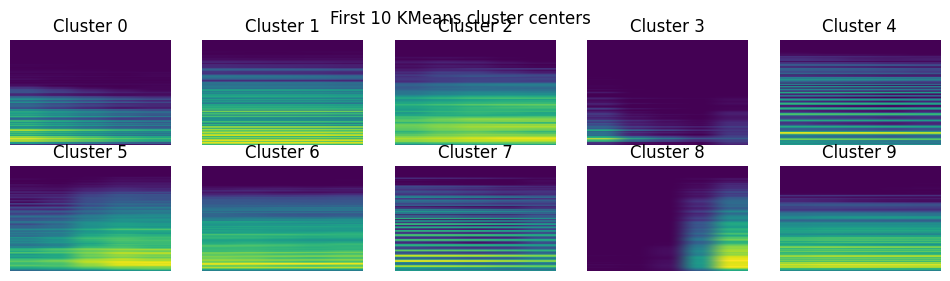

Cluster distribution in first sequence: {np.int32(0): np.int64(19), np.int32(2): np.int64(28), np.int32(3): np.int64(44), np.int32(5): np.int64(3), np.int32(8): np.int64(7), np.int32(9): np.int64(60), np.int32(12): np.int64(1), np.int32(13): np.int64(16), np.int32(14): np.int64(50), np.int32(24): np.int64(10), np.int32(28): np.int64(17), np.int32(41): np.int64(23), np.int32(42): np.int64(17), np.int32(48): np.int64(5), np.int32(49): np.int64(3), np.int32(54): np.int64(5), np.int32(58): np.int64(12)}


([[np.int32(42),
   np.int32(42),
   np.int32(41),
   np.int32(54),
   np.int32(3),
   np.int32(3),
   np.int32(24),
   np.int32(42),
   np.int32(42),
   np.int32(14),
   np.int32(14),
   np.int32(14),
   np.int32(14),
   np.int32(2),
   np.int32(42),
   np.int32(42),
   np.int32(0),
   np.int32(28),
   np.int32(3),
   np.int32(24),
   np.int32(42),
   np.int32(42),
   np.int32(41),
   np.int32(48),
   np.int32(42),
   np.int32(42),
   np.int32(14),
   np.int32(14),
   np.int32(2),
   np.int32(14),
   np.int32(2),
   np.int32(42),
   np.int32(42),
   np.int32(41),
   np.int32(24),
   np.int32(14),
   np.int32(14),
   np.int32(41),
   np.int32(54),
   np.int32(3),
   np.int32(8),
   np.int32(2),
   np.int32(14),
   np.int32(58),
   np.int32(58),
   np.int32(58),
   np.int32(58),
   np.int32(2),
   np.int32(14),
   np.int32(14),
   np.int32(41),
   np.int32(54),
   np.int32(3),
   np.int32(8),
   np.int32(14),
   np.int32(14),
   np.int32(13),
   np.int32(54),
   np.int32(2),
   np.int32

In [48]:
import numpy as np
from sklearn.cluster import KMeans

def quantize_slices(sequences, n_clusters=64, visualize=False):
    """
    Flatten slices, cluster them via KMeans, and optionally visualize cluster centers.

    Args:
        sequences: list of list of slices from extract_spectrograms
            sequences[i][j] -> slice (n_mels, frames_per_slice)
        n_clusters: number of clusters for KMeans
        visualize: whether to plot cluster centers and distribution
    """
    
    # Flatten all slices for KMeans
    all_slices_flat = []
    for audio_seq in sequences:
        for slice_ in audio_seq:
            all_slices_flat.append(slice_.flatten())  # shape: n_mels*frames_per_slice
    all_slices_flat = np.array(all_slices_flat, dtype=np.float32)

    print(f"Quantizing {all_slices_flat.shape[0]} slices into {n_clusters} clusters...")
    
    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(all_slices_flat)
    
    # Map each slice back to a cluster index
    sequences_discrete = []
    for audio_seq in sequences:
        discrete_seq = [kmeans.predict(slice_.flatten().reshape(1, -1))[0] for slice_ in audio_seq]
        sequences_discrete.append(discrete_seq)
    
    if visualize:
        # Plot first 10 cluster centers
        plt.figure(figsize=(12, 3))
        for i, center in enumerate(kmeans.cluster_centers_[:10]):
            plt.subplot(2, 5, i+1)
            plt.imshow(center.reshape(audio_seq[0].shape), aspect='auto', origin='lower', cmap='viridis')
            plt.title(f"Cluster {i}")
            plt.axis('off')
        plt.suptitle("First 10 KMeans cluster centers")
        plt.show()

        # Print distribution of clusters in first sequence
        first_seq = sequences_discrete[0]
        unique, counts = np.unique(first_seq, return_counts=True)
        print("Cluster distribution in first sequence:", dict(zip(unique, counts)))

    return sequences_discrete, kmeans

quantize_slices(dev_test_sequences, visualize=True)

### Convert Cluster ID back to spectrogram / audio (Decoding Function)

In [30]:
def clusters_to_spectrogram(generated_clusters, exemplars, smoothing_sigma=1.0):
    """
    Convert cluster IDs back to Mel spectrogram slices.
    Optionally smooth in time to avoid abrupt jumps (if smoothing_sigma = None, no smoothing)
    """
    slices = [exemplars[cid] for cid in generated_clusters]  # Use real exemplar slices
    # slices = [kmeans.cluster_centers_[cid].reshape(n_mels, frames_per_slice) for cid in generated_clusters]
    S_gen = np.hstack(slices)  # concatenate along time
    # Optional smoothing
    if smoothing_sigma:
        from scipy.ndimage import gaussian_filter1d
        S_gen = gaussian_filter1d(S_gen, sigma=smoothing_sigma, axis=1)
    return S_gen

def spectrogram_to_audio(S_db, sr=22050, n_fft=2048, hop_length=512):
    S_power = librosa.db_to_power(S_db)
    y = librosa.feature.inverse.mel_to_audio(S_power, sr=sr, n_fft=n_fft, hop_length=hop_length, n_iter=60)
    return y

## Training HMM (first-order)

In [31]:
from hmmlearn import hmm

def train_hmm(sequences_discrete, n_states=64, n_iter=100, visualize=False):
    """
    Train a discrete HMM and optionally visualize the transition matrix.
    """
    lengths = [len(seq) for seq in sequences_discrete]
    X = np.concatenate(sequences_discrete).reshape(-1, 1)

    # Determine number of unique symbols (cluster IDs)
    n_clusters = int(np.max(X)) + 1
    model = hmm.CategoricalHMM(n_components=n_states, n_features=n_clusters, n_iter=n_iter, verbose=True, random_state=42)
    
    print(f"Training HMM with {n_states} states on {X.shape[0]} observations...")
    model.fit(X, lengths=lengths)
    print("HMM training complete.")
    
    if visualize:
        # Show transition matrix
        plt.figure(figsize=(6, 5))
        plt.imshow(model.transmat_, cmap='viridis', interpolation='nearest')
        plt.colorbar()
        plt.title("HMM Transition Matrix")
        plt.xlabel("To state")
        plt.ylabel("From state")
        plt.show()
        print("Transition matrix (first 5 states):\n", model.transmat_[:5, :5])
        
    return model

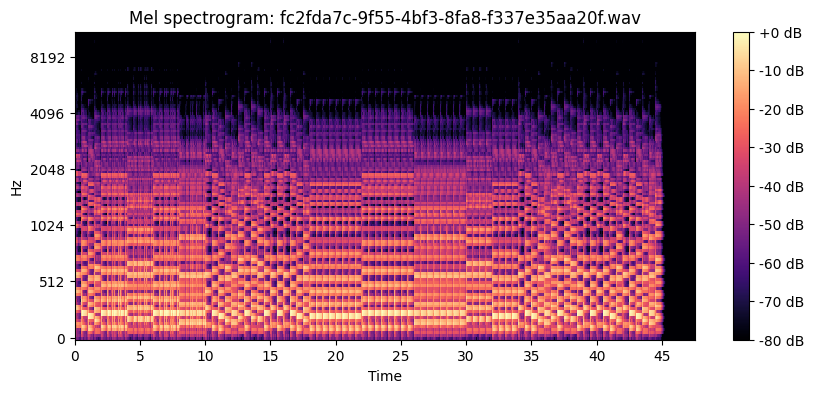

First piece's spectrogram shape: (128, 2047), Num slices: 410
Quantizing 22598 slices into 64 clusters...


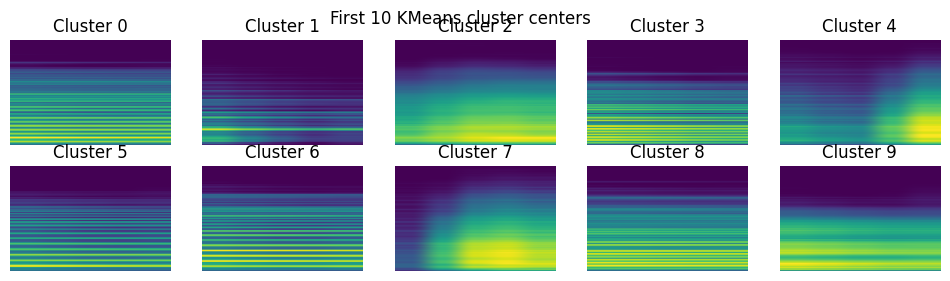

Cluster distribution in first sequence: {np.int32(0): np.int64(96), np.int32(1): np.int64(20), np.int32(2): np.int64(36), np.int32(8): np.int64(24), np.int32(14): np.int64(1), np.int32(16): np.int64(24), np.int32(17): np.int64(38), np.int32(26): np.int64(11), np.int32(28): np.int64(56), np.int32(29): np.int64(1), np.int32(32): np.int64(49), np.int32(47): np.int64(18), np.int32(48): np.int64(19), np.int32(55): np.int64(1), np.int32(59): np.int64(16)}
Training HMM with 64 states on 22598 observations...


         1  -93991.29101245             +nan
         2  -82410.77804762  +11580.51296483
         3  -74383.02982667   +8027.74822095
         4  -68431.10749213   +5951.92233453
         5  -65096.98348338   +3334.12400875
         6  -63002.34377925   +2094.63970414
         7  -61476.63149347   +1525.71228578
         8  -60387.86435042   +1088.76714305
         9  -59605.46715586    +782.39719455


HMM training complete.


        10  -58890.44480248    +715.02235338


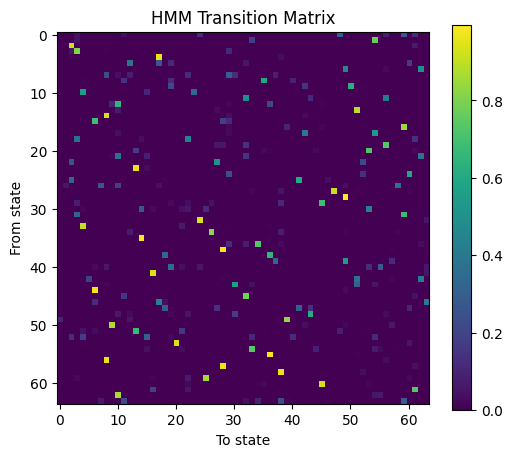

Transition matrix (first 5 states):
 [[4.56262792e-145 5.75734913e-026 6.48740946e-050 4.93034907e-002
  4.83898738e-015]
 [7.28943567e-020 3.83622199e-016 3.85289146e-050 4.86004573e-002
  1.17202664e-007]
 [3.06501430e-041 9.47128566e-029 9.20087204e-001 4.62655286e-018
  2.85054454e-040]
 [1.49235434e-094 9.35717146e-031 5.74006087e-002 8.11621378e-001
  3.04738612e-003]
 [5.39091972e-064 8.13924667e-014 4.05591262e-008 2.24599972e-069
  4.03970290e-014]]


In [49]:
def build_hmm_from_audio(audio_files, n_clusters=64, n_states=64, visualize=True):
    sequences, slice_sec, hop_length = extract_spectrograms(audio_files, note_fraction=0.25, visualize=visualize)
    sequences_discrete, kmeans = quantize_slices(sequences, n_clusters=n_clusters, visualize=visualize)
    hmm_model = train_hmm(sequences_discrete, n_states=n_states, n_iter=10, visualize=visualize)
    return sequences_discrete, kmeans, hmm_model, slice_sec

sequences_discrete, kmeans, hmm_model, slice_sec = build_hmm_from_audio(list(TRAIN_DIR.glob('*.wav')))

## Prediction with HMM (first-order)

### HMM Prediction of next cluster

In [50]:
def audio_to_cluster_sequence(audio_path, kmeans, slice_sec, hop_length, sr=22050, n_mels=128, n_fft=2048, pad=True):
    # Load audio
    y, _ = librosa.load(audio_path, sr=sr)
    slices, _ = slice_waveform(y, sr=sr, slice_sec=slice_sec,
                               n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, pad=pad)
    # Map slices to cluster IDs
    cluster_seq = [kmeans.predict(slice_.reshape(1,-1))[0] for slice_ in slices]
    return cluster_seq

# TODO: Variable-order HMM
# hmmlearn implements first-order hidden Markov models only.
# During sampling, hmmlearn cannot condition on a given observed sequence—it generates observations based on the learned model from scratch.
def generate_hmm_continuation(hmm_model, cluster_seq, n_steps=10):
    """
    Generate continuation cluster IDs using HMM.
    - cluster_seq: observed sequence of clusters from audio
    - n_steps: number of slices to generate
    """
    # but CategoricalHMM has no conditional sampling…
    # So simplest is sample from model normally
    generated_obs, _ = hmm_model.sample(n_steps)
    return generated_obs.flatten()


### Convert cluster back to spectrogram and audio

cluster sequence of the test file: [np.int32(63), np.int32(63), np.int32(61), np.int32(29), np.int32(1), np.int32(1), np.int32(7), np.int32(63), np.int32(63), np.int32(41), np.int32(9), np.int32(41), np.int32(41), np.int32(41), np.int32(63), np.int32(63), np.int32(10), np.int32(29), np.int32(1), np.int32(7), np.int32(63), np.int32(63), np.int32(61), np.int32(4), np.int32(63), np.int32(63), np.int32(41), np.int32(38), np.int32(41), np.int32(41), np.int32(41), np.int32(63), np.int32(63), np.int32(10), np.int32(7), np.int32(41), np.int32(38), np.int32(61), np.int32(10), np.int32(1), np.int32(37), np.int32(41), np.int32(41), np.int32(41), np.int32(19), np.int32(2), np.int32(19), np.int32(41), np.int32(41), np.int32(38), np.int32(61), np.int32(10), np.int32(1), np.int32(46), np.int32(41), np.int32(41), np.int32(9), np.int32(10), np.int32(2), np.int32(41), np.int32(41), np.int32(19), np.int32(59), np.int32(19), np.int32(19), np.int32(41), np.int32(41), np.int32(41), np.int32(19), np.int32(41

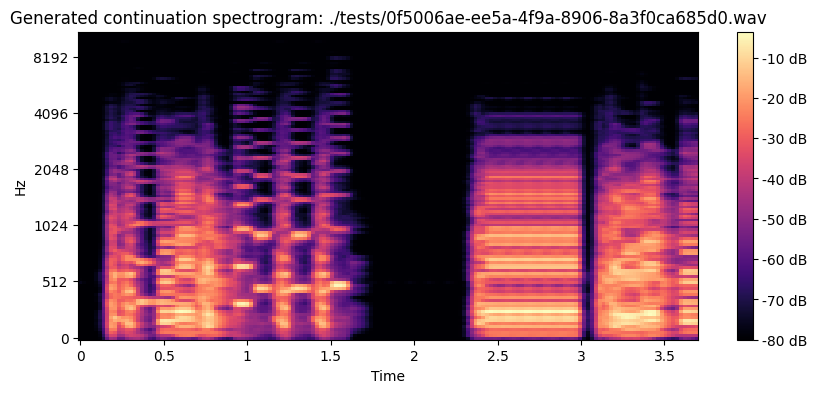

In [101]:
audio_path = "./tests/0f5006ae-ee5a-4f9a-8906-8a3f0ca685d0.wav"
# Step 1: map to cluster sequence
cluster_seq = audio_to_cluster_sequence(audio_path, kmeans, slice_sec, hop_length)
print(f"cluster sequence of the test file: {cluster_seq}")

# Step 2: generate continuation cluster IDs
generated_clusters = generate_hmm_continuation(hmm_model, cluster_seq, n_steps=32)
print(f"generated continuation (cluster IDs): {generated_clusters}")

# Step 3: convert clusters to spectrogram
frames_per_slice = int(slice_sec * sr / hop_length)
S_gen = clusters_to_spectrogram(generated_clusters, exemplars, smoothing_sigma=0.8)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_gen, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Generated continuation spectrogram: {audio_path}")
plt.show()

# Step 4: reconstruct audio
y_gen = spectrogram_to_audio(S_gen, sr=sr, n_fft=2048, hop_length=hop_length)
# Listen to generated continuation
from IPython.display import Audio
Audio(y_gen, rate=sr)


## Training Variable-Order HMM

In [102]:
import numpy as np
from collections import defaultdict, Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

class VOHMM:
    def __init__(self, n_hidden=16, order=2, verbose=True):
        self.n_hidden = n_hidden
        self.order = order
        self.verbose = verbose

        # Transition table: {history_length: {history_tuple: Counter(next_hidden)}}
        self.transitions = defaultdict(lambda: defaultdict(Counter))
        # Emission table: list of Counters for each hidden state
        self.emissions = [Counter() for _ in range(n_hidden)]
        # Cluster vocabulary
        self.cluster_vocab = None
        self.cluster_to_idx = None

    def fit(self, sequences):
        """
        Fit VOHMM to sequences of cluster IDs.
        sequences: list of lists of cluster IDs
        """
        # Build cluster vocabulary
        self.cluster_vocab = sorted(set(c for seq in sequences for c in seq))
        self.cluster_to_idx = {c:i for i,c in enumerate(self.cluster_vocab)}

        # Encode sequences as indices
        sequences_idx = [[self.cluster_to_idx[c] for c in seq] for seq in sequences]

        # Randomly assign hidden states
        hidden_assignments = []
        if self.verbose:
            print(f"Assigning initial random hidden states to {len(sequences_idx)} sequences...")
        for seq in tqdm(sequences_idx, desc="Initializing hidden states"):
            hidden_seq = np.random.choice(self.n_hidden, size=len(seq))
            hidden_assignments.append(hidden_seq)

        # Count emissions
        if self.verbose:
            print("Counting emissions...")
        for seq, hidden_seq in tqdm(zip(sequences_idx, hidden_assignments), total=len(sequences_idx), desc="Counting emissions"):
            for obs, h in zip(seq, hidden_seq):
                self.emissions[h][obs] += 1

        # Count transitions for all history lengths
        if self.verbose:
            print(f"Counting variable-order transitions (order={self.order})...")
        for hidden_seq in tqdm(hidden_assignments, desc="Counting transitions"):
            for t in range(1, len(hidden_seq)):
                max_len = min(self.order, t)
                for l in range(1, max_len+1):
                    history = tuple(hidden_seq[t-l:t])
                    next_h = hidden_seq[t]
                    self.transitions[l][history][next_h] += 1

        if self.verbose:
            print("VOHMM training complete.")

    def plot_emissions(self, normalize=True, cmap='viridis'):
        """
        Visualize emissions of all hidden states as a heatmap.

        Args:
            normalize: if True, each hidden state's emissions are normalized to sum=1
            cmap: matplotlib colormap
        """
        vocab_size = len(self.cluster_vocab)
        emission_matrix = np.zeros((self.n_hidden, vocab_size))

        for h, counter in enumerate(self.emissions):
            for c_idx, cluster in enumerate(self.cluster_vocab):
                emission_matrix[h, c_idx] = counter[cluster]
            if normalize and emission_matrix[h].sum() > 0:
                emission_matrix[h] /= emission_matrix[h].sum()

        plt.figure(figsize=(12,6))
        plt.imshow(emission_matrix, aspect='auto', origin='lower', cmap=cmap)
        plt.colorbar(label='Emission Probability' if normalize else 'Counts')
        plt.xlabel("Cluster ID")
        plt.ylabel("Hidden State")
        plt.title("Emission Probabilities of Hidden States")
        plt.xticks(ticks=np.arange(vocab_size), labels=self.cluster_vocab, rotation=90)
        plt.yticks(ticks=np.arange(self.n_hidden))
        plt.tight_layout()
        plt.show()

    def generate(self, n_steps=32, alpha=0.7, local_hidden_sequence=None, start_hidden=None):
        """
        Generate cluster sequence from VOHMM.
        alpha: weight for local sequence
        """
        generated_clusters = []

        # Initialize hidden history
        if start_hidden is None:
            hidden_history = [np.random.choice(self.n_hidden)] * self.order
        else:
            hidden_history = list(start_hidden)

        for t in range(n_steps):
            # --- Determine next hidden state ---
            next_h = None
            found = False
            for backoff in range(self.order, 0, -1):
                history_tuple = tuple(hidden_history[-backoff:])
                global_counts = self.transitions[backoff].get(history_tuple, {})

                # Local counts
                local_counts = Counter()
                if local_hidden_sequence is not None and len(local_hidden_sequence) >= backoff:
                    for i in range(len(local_hidden_sequence)-backoff):
                        if tuple(local_hidden_sequence[i:i+backoff]) == history_tuple:
                            next_state = local_hidden_sequence[i+backoff]
                            local_counts[next_state] += 1

                all_choices = sorted(set(global_counts.keys()) | set(local_counts.keys()))
                if not all_choices:
                    continue  # backoff

                probs = []
                for h in all_choices:
                    g_prob = global_counts[h]/sum(global_counts.values()) if h in global_counts else 0
                    l_prob = local_counts[h]/sum(local_counts.values()) if h in local_counts else 0
                    probs.append(alpha*l_prob + (1-alpha)*g_prob)
                probs = np.array(probs)
                probs /= probs.sum()
                next_h = np.random.choice(all_choices, p=probs)
                found = True
                break

            if not found:
                next_h = np.random.choice(self.n_hidden)
                if self.verbose:
                    print(f"Step {t}: No matching history, picked random hidden state {next_h}")

            hidden_history.append(next_h)

            # --- Sample observation from emission ---
            emission_counter = self.emissions[next_h]
            obs_choices = list(emission_counter.keys())
            counts = np.array([emission_counter[c] for c in obs_choices])
            probs_obs = counts / counts.sum()
            next_obs = np.random.choice(obs_choices, p=probs_obs)
            generated_clusters.append(next_obs)

            # Visualization / verbose
            if self.verbose:
                print(f"Step {t}: hidden={next_h}, obs={next_obs}")

        return generated_clusters

    def infer_hidden_sequence(self, observed_sequence):
        """
        Simple Viterbi-like decoding using max emission probability (not true HMM)
        """
        hidden_seq = []
        for obs in observed_sequence:
            best_h = np.argmax([self.emissions[h][obs] if obs in self.emissions[h] else 0 for h in range(self.n_hidden)])
            hidden_seq.append(best_h)
        return hidden_seq


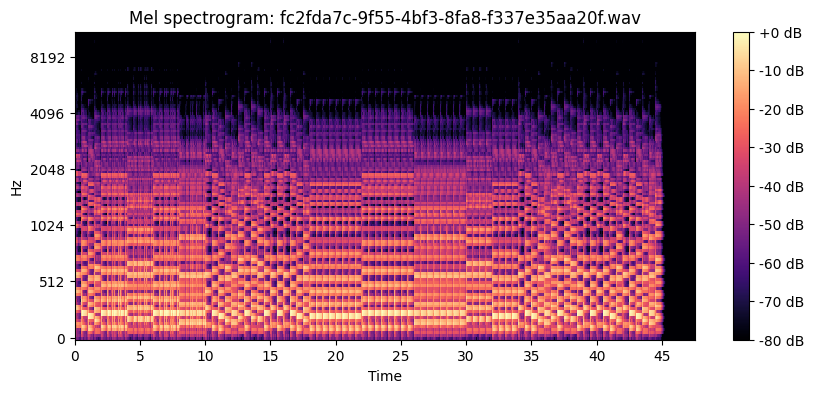

First piece's spectrogram shape: (128, 2047), Num slices: 410
Quantizing 22598 slices into 64 clusters...


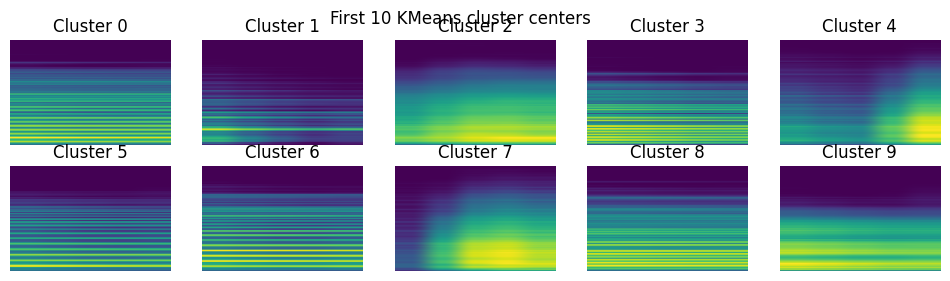

Cluster distribution in first sequence: {np.int32(0): np.int64(96), np.int32(1): np.int64(20), np.int32(2): np.int64(36), np.int32(8): np.int64(24), np.int32(14): np.int64(1), np.int32(16): np.int64(24), np.int32(17): np.int64(38), np.int32(26): np.int64(11), np.int32(28): np.int64(56), np.int32(29): np.int64(1), np.int32(32): np.int64(49), np.int32(47): np.int64(18), np.int32(48): np.int64(19), np.int32(55): np.int64(1), np.int32(59): np.int64(16)}
Assigning initial random hidden states to 75 sequences...


Initializing hidden states: 100%|██████████| 75/75 [00:00<00:00, 107436.07it/s]


Counting emissions...


Counting emissions: 100%|██████████| 75/75 [00:00<00:00, 24225.86it/s]


Counting variable-order transitions (order=50)...


Counting transitions: 100%|██████████| 75/75 [00:02<00:00, 30.31it/s]

VOHMM training complete.


In [107]:
n_clusters=64
n_states=64
visualize=True
audio_files = list(TRAIN_DIR.glob('*.wav'))
sequences, slice_sec, hop_length = extract_spectrograms(audio_files, note_fraction=0.25, visualize=visualize)
sequences_discrete, kmeans = quantize_slices(sequences, n_clusters=n_clusters, visualize=visualize)

# Step 2: train VOHMM
vohmm = VOHMM(n_hidden=n_states, order=50, verbose=True)
vohmm.fit(sequences_discrete)
# vohmm.plot_emissions()


## Prediction with VOHMM

cluster sequence of the test file: [np.int32(63), np.int32(63), np.int32(61), np.int32(29), np.int32(1), np.int32(1), np.int32(7), np.int32(63), np.int32(63), np.int32(41), np.int32(9), np.int32(41), np.int32(41), np.int32(41), np.int32(63), np.int32(63), np.int32(10), np.int32(29), np.int32(1), np.int32(7), np.int32(63), np.int32(63), np.int32(61), np.int32(4), np.int32(63), np.int32(63), np.int32(41), np.int32(38), np.int32(41), np.int32(41), np.int32(41), np.int32(63), np.int32(63), np.int32(10), np.int32(7), np.int32(41), np.int32(38), np.int32(61), np.int32(10), np.int32(1), np.int32(37), np.int32(41), np.int32(41), np.int32(41), np.int32(19), np.int32(2), np.int32(19), np.int32(41), np.int32(41), np.int32(38), np.int32(61), np.int32(10), np.int32(1), np.int32(46), np.int32(41), np.int32(41), np.int32(9), np.int32(10), np.int32(2), np.int32(41), np.int32(41), np.int32(19), np.int32(59), np.int32(19), np.int32(19), np.int32(41), np.int32(41), np.int32(41), np.int32(19), np.int32(41

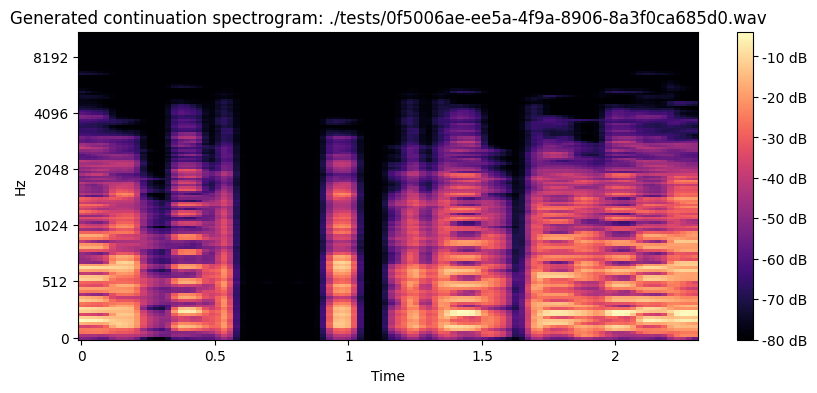

In [110]:
audio_path = "./tests/0f5006ae-ee5a-4f9a-8906-8a3f0ca685d0.wav"
# Step 1: map to cluster sequence
cluster_seq = audio_to_cluster_sequence(audio_path, kmeans, slice_sec, hop_length)
print(f"cluster sequence of the test file: {cluster_seq}")

# Step 2: generate continuation cluster IDs
last_hidden = vohmm.infer_hidden_sequence(cluster_seq)[-vohmm.order:]
generated_clusters = vohmm.generate(start_hidden=last_hidden, n_steps=20, alpha=0.8)
print(f"generated continuation (cluster IDs): {generated_clusters}")

# Step 3: convert clusters to spectrogram
frames_per_slice = int(slice_sec * sr / hop_length)
S_gen = clusters_to_spectrogram(generated_clusters, exemplars, smoothing_sigma=0.8)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_gen, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Generated continuation spectrogram: {audio_path}")
plt.show()

# Step 4: reconstruct audio
y_gen = spectrogram_to_audio(S_gen, sr=sr, n_fft=2048, hop_length=hop_length)
# Listen to generated continuation
from IPython.display import Audio
Audio(y_gen, rate=sr)